In [2]:
# Import Yahoo Finance API
import yfinance as yf

# Import backtesting utils
import backtest_tools.portfolio_tools as backtest
import statsmodels.api as sm

# Import utils
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

Load Returns

In [62]:
import pickle 

returns_path = r'C:\Users\marcu\Documents\Quant\Programming\Data\russell_300_returns.pickle'

with open(returns_path, 'rb') as handler:
    new_returns = pickle.load(handler)

In [4]:
new_returns = new_returns.loc['2020':].dropna()

In [53]:
def drift_adjusted_sharpe_ratio(returns: pd.Series, normalize_residuals='Normalization', plot=False):

    if (normalize_residuals=='STD' or normalize_residuals=='Min-Max' or normalize_residuals=='Min-Max T-Stat'):
        returns = returns.dropna()
        cum_rets = backtest.cumulative_returns(returns)
        cum_rets = (cum_rets - cum_rets.min()) / (cum_rets.max() - cum_rets.min())
    else:
        # Scale reutrns to 10% vol
        returns = backtest.scale_vol(returns.dropna())
        cum_rets = backtest.cumulative_returns(returns)
    
    # # Construct OLS regression of portfolio returns over time
    # cum_rets = backtest.cumulative_returns(returns, log_rets=False)
    # # Normalize Cumulative Returns s.t. Cumulative Returns end at 1
    # cum_rets = (cum_rets - cum_rets.min()) / (cum_rets.max() - cum_rets.min())
    
    # Get numerical values of time as exog variable
    date_index = np.arange(cum_rets.index.size)
    exog = sm.add_constant(date_index)  

    # Build model
    model = sm.OLS(cum_rets, exog)
    portfolio_regression = model.fit()

    # Get regression params
    alpha = portfolio_regression.params[0]
    beta = portfolio_regression.params[1]

    # Compute best fit line and format
    reg_pred = date_index * beta + alpha
    reg_pred = pd.Series(reg_pred, index=returns.index, name='Predicted Returns')

    # ----------------------------------- Plot Returns + Best Fit Line -----------------------------------
    if plot:
        plt.figure(figsize=(20, 10))
        cum_rets.plot()
        reg_pred.plot()
        plt.legend()
        plt.show()

    # Build Regression DataFrame
    regression_df = pd.concat([cum_rets, reg_pred], axis=1)

    # Get squared residuals and normalized squared residuals
    regression_df['Squared Error'] = np.square(regression_df.iloc[:,0] - regression_df.iloc[:,1])
    regression_df['Cubed Error'] = (regression_df.iloc[:,0] - regression_df.iloc[:,1])**3
    regression_df['Normalized Squared Error'] = (regression_df['Squared Error'] - regression_df['Squared Error'].min()) / (regression_df['Squared Error'].max() - regression_df['Squared Error'].min())  

    # Get MSE and normalized MSE
    mse = regression_df['Squared Error'].mean()
    mce = regression_df['Cubed Error'].mean()
    normalized_mse = regression_df['Normalized Squared Error'].mean()
    std_squared_error = regression_df['Squared Error'].std()
    std_cubed_error = regression_df['Cubed Error'].std()
    std_normalized_squared_error = regression_df['Normalized Squared Error'].std()
    
    # Get Drift Adjusted Sharpe Ratio
    drift_adjusted_sharpe_ratio = (beta / mse) * 10 # Good. Most intuitive. We want to penalize for the average size of squared error. Sure, it's good to account for std, but ultimately we want the least consisitent large error.
    normed_drift_adjusted_sharpe_ratio = (beta / normalized_mse) * 100 # Computing the mean of min-max normalzied residuls can radically alter the residuals' behaviour. (one outlier can cluster observations).
    std_drift_adjusted_sharpe_ratio = (beta / std_squared_error) # Also potentially good.
    std_squared_error_drift_adjusted_sharpe_ratio = (beta / std_normalized_squared_error) # Again, std of normalized residuals could be misleading... thus we should just use min-max cum rets and compute MSE.
    t_stat_drift_adjusted_sharpe_ratio = beta / (mse / std_squared_error) # Note great. beta / t-stat of squared error... supresses the true magnitude of the error and only heightens those that are "significant".

    if plot:
        print(f'MSE: {mse}')
        print(f'Normalized MSE: {normalized_mse}')
        print(f'Beta: {beta}')
        print('='*50)
        print(f'DASR: {drift_adjusted_sharpe_ratio}')
        print(f'Normalized DASR: {normed_drift_adjusted_sharpe_ratio}')

    sharpe_ratio = backtest.sharpe_ratio(returns)
    
    

    # If DASR is calculated by normalizing residuals for MSE
    if normalize_residuals == 'Normalized':
        return pd.Series({'DASR' : normed_drift_adjusted_sharpe_ratio, 'SR' : sharpe_ratio}, name=returns.name)
    
    elif normalize_residuals == 'STD':
        return pd.Series({'DASR' : std_drift_adjusted_sharpe_ratio, 'SR' : sharpe_ratio}, name=returns.name)
    
    elif (normalize_residuals == 'Non-Normalized' or normalize_residuals=='Min-Max'):
        return pd.Series({'DASR' : drift_adjusted_sharpe_ratio, 'SR' : sharpe_ratio}, name=returns.name)
    
    elif normalize_residuals == 'Normalized Residuals':
        return pd.Series({'DASR' : std_squared_error_drift_adjusted_sharpe_ratio, 'SR' : sharpe_ratio}, name=returns.name)
    
    elif normalize_residuals == 'Min-Max T-Stat':
        return pd.Series({'DASR' : t_stat_drift_adjusted_sharpe_ratio, 'SR' : sharpe_ratio}, name=returns.name)
    
    

Compute DASR (min max cum rets) = beta / mse square error of normalized cumulative returns

In [63]:
drift_adjusted_sharpe_ratio_normalized_cum_rets = {}

for ticker, tmp_returns in new_returns.items():
    drift_adjusted_sharpe_ratio_normalized_cum_rets[ticker] = drift_adjusted_sharpe_ratio(returns = tmp_returns, normalize_residuals='Min-Max')

drift_adjusted_sharpe_ratio_normalized_cum_rets = pd.DataFrame(drift_adjusted_sharpe_ratio_normalized_cum_rets)
drift_adjusted_sharpe_ratio_normalized_cum_rets

C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


,AAPL,MSFT,AMZN,GOOGL,GOOG,NVDA,XOM,TSLA,UNH,JNJ,...,TUP,RLMD,DHC,INSG,VXRT,EGIO,TTCF,YMAB,EIGR,GOSS
DASR,0.113736,0.12726,0.143147,0.180308,0.173141,0.093119,0.041364,0.071717,0.223136,0.893357,...,-0.013398,-0.002705,-0.018870,0.000079,-0.066431,-0.000779,-0.020836,-0.064866,-0.080999,-0.326577
SR,0.903092,0.75083,0.771634,0.649276,0.650934,0.873286,0.358626,0.947597,0.784232,0.569259,...,0.151634,0.256055,-0.081211,0.142568,0.094753,0.212168,-0.384775,-0.017581,-0.018841,-0.048980


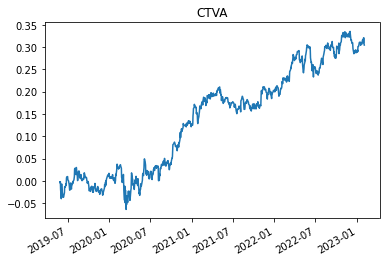

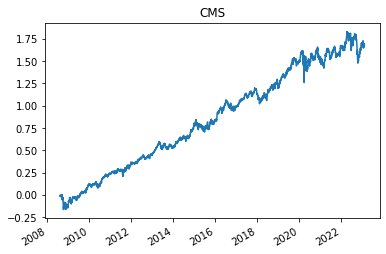

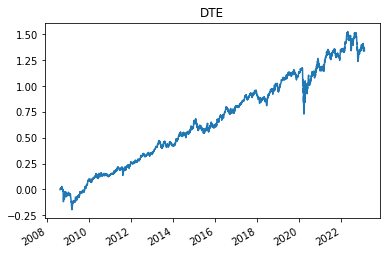

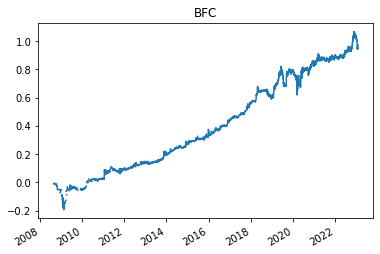

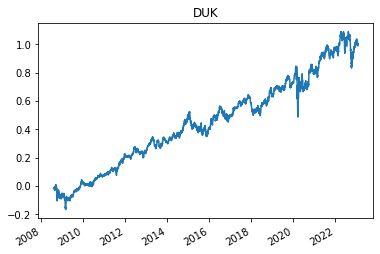

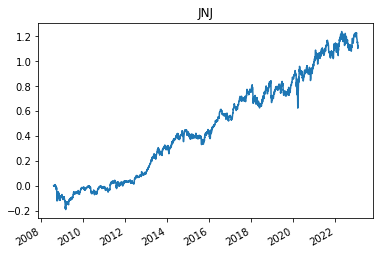

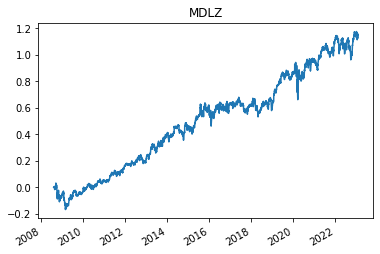

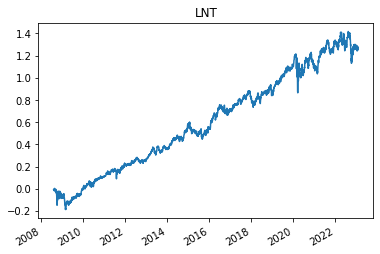

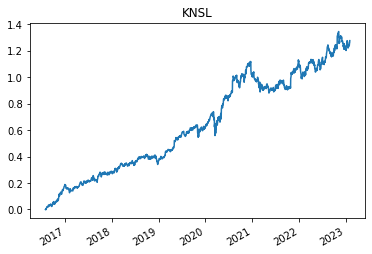

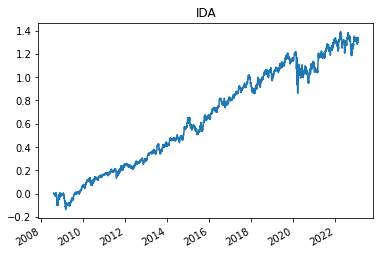

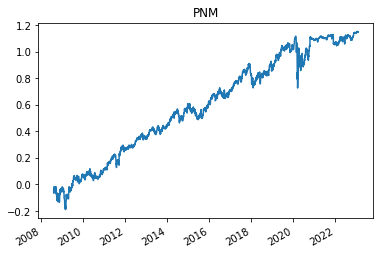

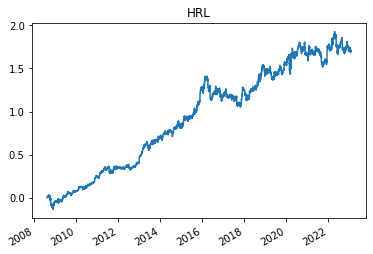

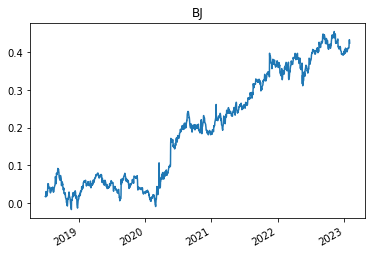

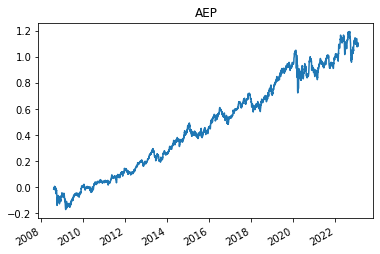

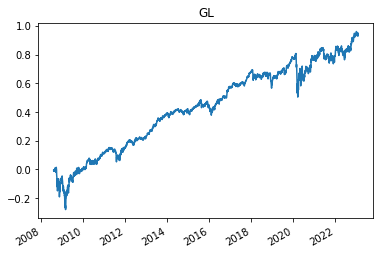

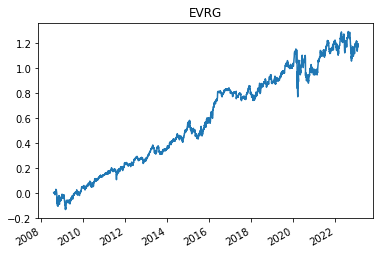

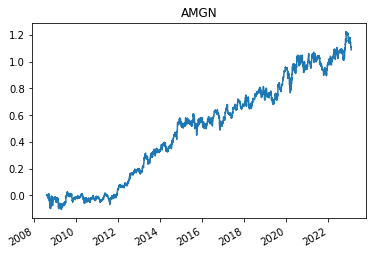

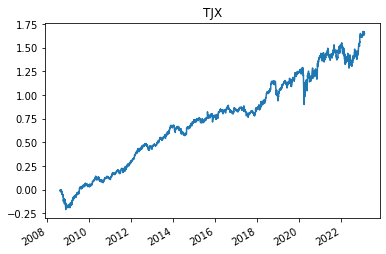

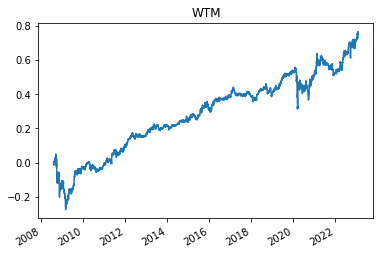

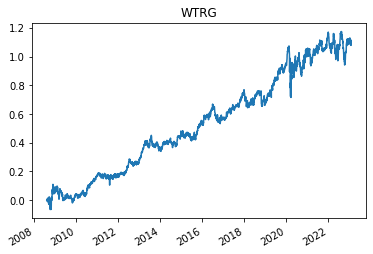

DASR    4.842448
SR      0.883662
dtype: float64


,CTVA,CMS,DTE,BFC,DUK,JNJ,MDLZ,LNT,KNSL,IDA,PNM,HRL,BJ,AEP,GL,EVRG,AMGN,TJX,WTM,WTRG
DASR,1.244317,1.026483,0.964510,0.900431,0.896996,0.893357,0.887797,0.871102,0.849226,0.834428,0.832652,0.824727,0.808498,0.807322,0.799308,0.784396,0.772620,0.763147,0.737027,0.731212
SR,0.769944,0.731330,0.637579,0.675152,0.525275,0.569259,0.577493,0.611468,1.314185,0.631480,0.578914,0.738607,0.820180,0.557016,0.509987,0.586570,0.558649,0.722872,0.429018,0.560189


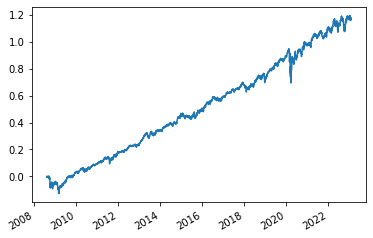

In [64]:
n_largest_dasr = drift_adjusted_sharpe_ratio_normalized_cum_rets.loc['DASR'].nlargest(20).index 

agg_n_largest_rets = {}
for ticker in n_largest_dasr:
    agg_n_largest_rets[ticker] = backtest.scale_vol(new_returns[ticker]) 
    backtest.cumulative_returns(agg_n_largest_rets[ticker]).plot(title=ticker)
    agg_n_largest_rets[ticker] *=1/len(n_largest_dasr)
    plt.show()
    
agg_n_largest_rets = pd.DataFrame(agg_n_largest_rets).sum(1)
backtest.cumulative_returns(agg_n_largest_rets).plot()
print(drift_adjusted_sharpe_ratio(returns = agg_n_largest_rets, normalize_residuals='Min-Max'))

drift_adjusted_sharpe_ratio_normalized_cum_rets[drift_adjusted_sharpe_ratio_normalized_cum_rets.loc['DASR'].nlargest(20).index]

Compute DASR (min max cum rets mse std) = beta / std of mse square error of normalized cumulative returns

In [65]:
drift_adjusted_sharpe_ratios_std = {}

for ticker in new_returns.columns:
    drift_adjusted_sharpe_ratios_std[ticker] = drift_adjusted_sharpe_ratio(returns = new_returns[ticker], normalize_residuals='STD')

drift_adjusted_sharpe_ratios_std = pd.DataFrame(drift_adjusted_sharpe_ratios_std)
drift_adjusted_sharpe_ratios_std

C:\Users\marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


,AAPL,MSFT,AMZN,GOOGL,GOOG,NVDA,XOM,TSLA,UNH,JNJ,...,TUP,RLMD,DHC,INSG,VXRT,EGIO,TTCF,YMAB,EIGR,GOSS
DASR,0.009108,0.009431,0.011373,0.008825,0.008651,0.003984,0.001892,0.004377,0.015969,0.062948,...,-0.001304,-0.000235,-0.001971,0.000004,-0.004649,-0.000051,-0.001968,-0.005517,-0.002973,-0.022764
SR,0.903092,0.750830,0.771634,0.649276,0.650934,0.873286,0.358626,0.947597,0.784232,0.569259,...,0.151634,0.256055,-0.081211,0.142568,0.094753,0.212168,-0.384775,-0.017581,-0.018841,-0.048980


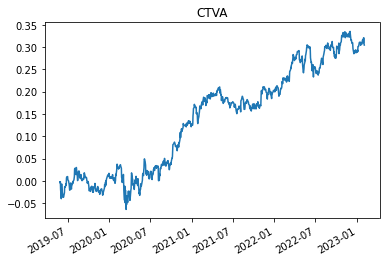

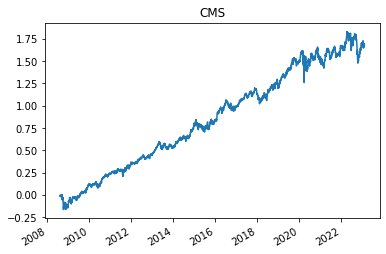

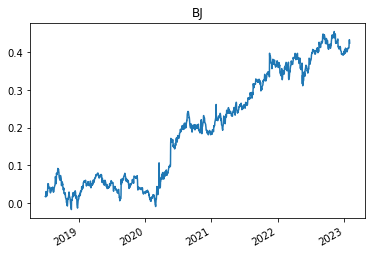

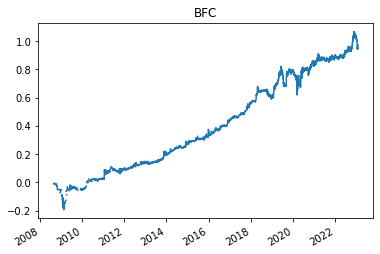

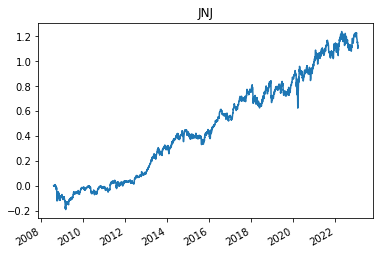

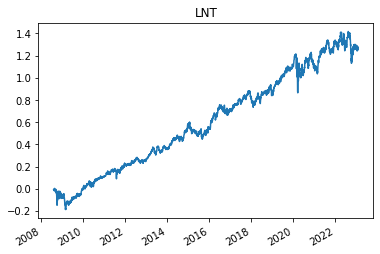

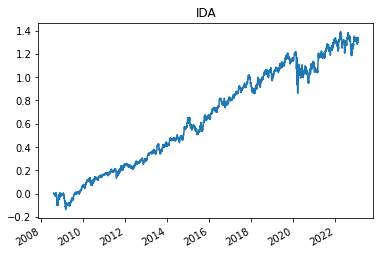

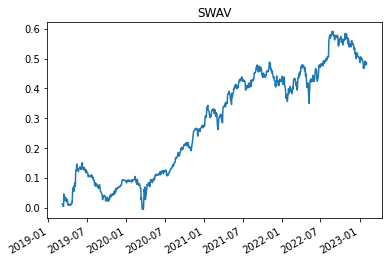

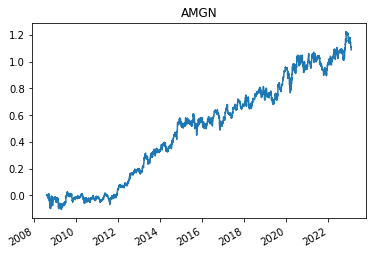

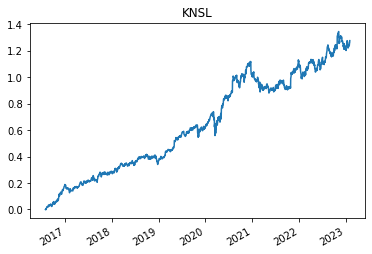

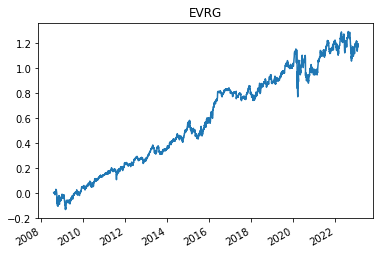

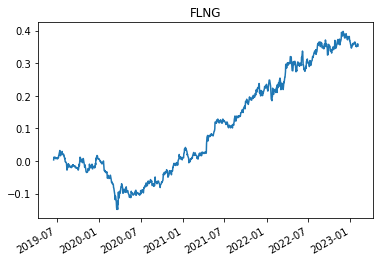

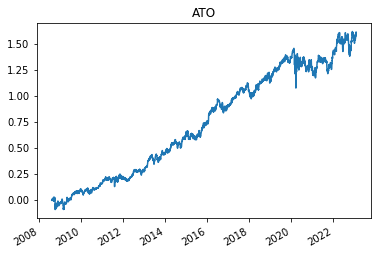

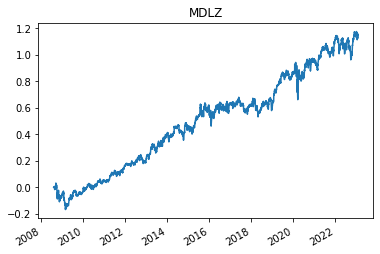

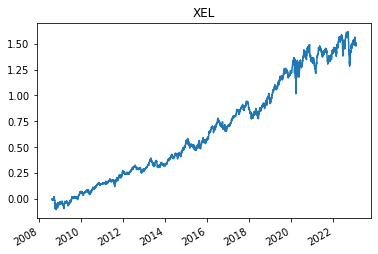

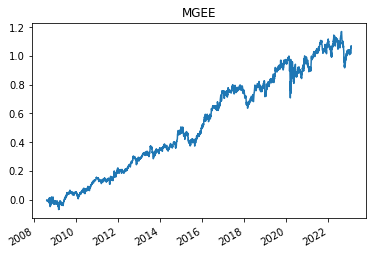

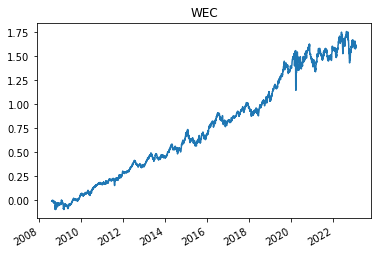

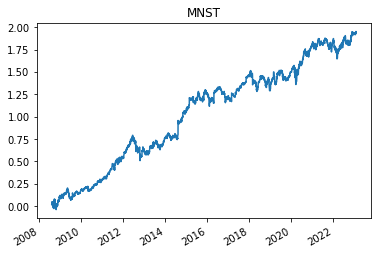

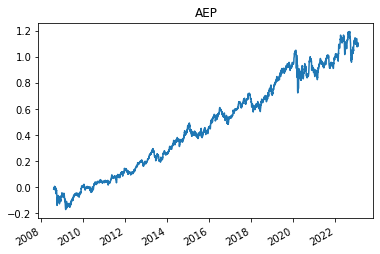

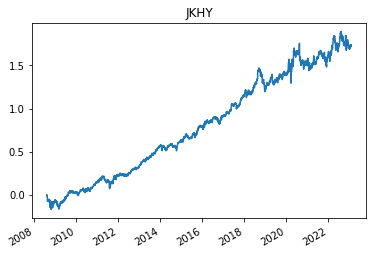

DASR    2.464486
SR      0.941743
dtype: float64


,CTVA,CMS,BJ,BFC,JNJ,LNT,IDA,SWAV,AMGN,KNSL,EVRG,FLNG,ATO,MDLZ,XEL,MGEE,WEC,MNST,AEP,JKHY
DASR,0.126908,0.06929,0.065654,0.064894,0.062948,0.061891,0.061047,0.060444,0.057199,0.056451,0.054396,0.054216,0.052468,0.052365,0.050946,0.050040,0.049573,0.048353,0.048113,0.046814
SR,0.769944,0.73133,0.820180,0.675152,0.569259,0.611468,0.631480,1.056340,0.558649,1.314185,0.586570,0.880836,0.708225,0.577493,0.678350,0.548274,0.709700,0.793524,0.557016,0.744655


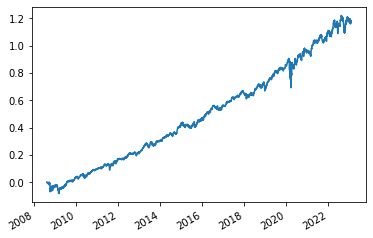

In [66]:
n_largest_dasr = drift_adjusted_sharpe_ratios_std.loc['DASR'].nlargest(20).index

agg_n_largest_rets = {}
for ticker in n_largest_dasr:
    agg_n_largest_rets[ticker] = backtest.scale_vol(new_returns[ticker]) 
    backtest.cumulative_returns(agg_n_largest_rets[ticker]).plot(title=ticker)
    agg_n_largest_rets[ticker] *=1/len(n_largest_dasr)
    plt.show()

pd.DataFrame(agg_n_largest_rets).to_clipboard()
agg_n_largest_rets = pd.DataFrame(agg_n_largest_rets).sum(1)
backtest.cumulative_returns(agg_n_largest_rets).plot()
print(drift_adjusted_sharpe_ratio(returns = agg_n_largest_rets, normalize_residuals='Min-Max'))

drift_adjusted_sharpe_ratios_std[drift_adjusted_sharpe_ratios_std.loc['DASR'].nlargest(20).index]


Compute DASR (min max cum rets mse t-stat)... t-stat only captures the statistical significance of residuals rather than the penalizing based on the sheer magnitute

In [54]:
drift_adjusted_sharpe_ratios_t_stat= {}

for ticker in new_returns.columns:
    drift_adjusted_sharpe_ratios_t_stat[ticker] = drift_adjusted_sharpe_ratio(returns = new_returns[ticker], normalize_residuals='Min-Max T-Stat')

drift_adjusted_sharpe_ratios_t_stat = pd.DataFrame(drift_adjusted_sharpe_ratios_t_stat)
drift_adjusted_sharpe_ratios_t_stat

,AAPL,MSFT,AMZN,GOOGL,GOOG,NVDA,XOM,TSLA,UNH,JNJ,...,TUP,RLMD,DHC,INSG,VXRT,EGIO,TTCF,YMAB,EIGR,GOSS
DASR,0.001332,0.000734,-0.000903,0.000623,0.000637,0.000709,0.002014,0.001122,0.002648,0.001606,...,-0.002675,-0.001375,-0.000900,-0.002296,-0.001124,0.000516,-0.000969,-0.001012,-0.000046,0.000468
SR,0.995308,0.662040,-0.062617,0.786788,0.784207,1.074036,1.837862,1.380132,1.360563,1.005742,...,0.407993,-0.234834,-0.111335,-0.425722,0.536290,0.424196,-0.516096,0.031027,0.265486,0.268520


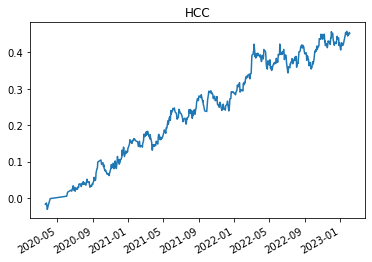

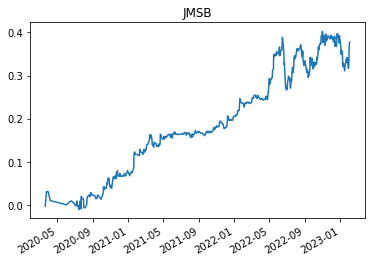

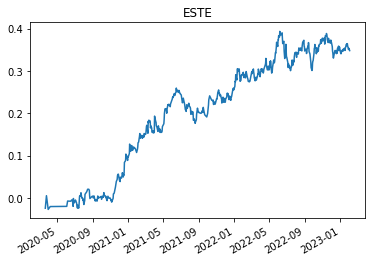

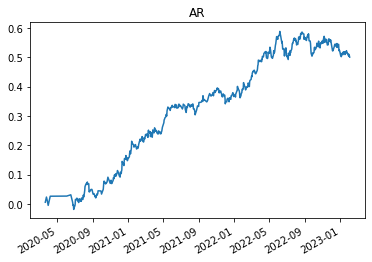

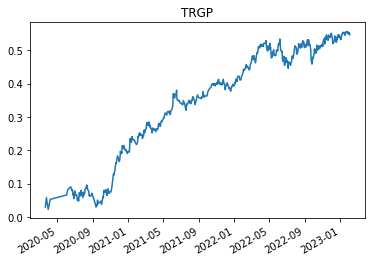

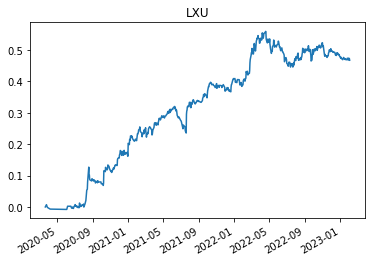

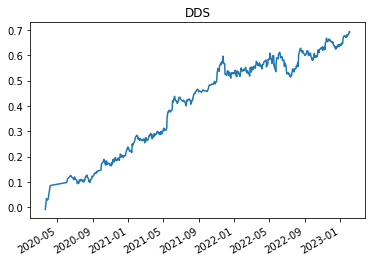

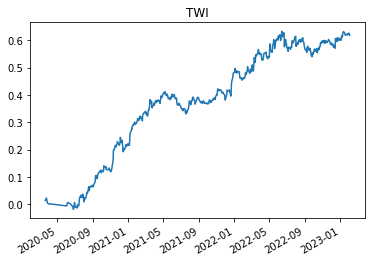

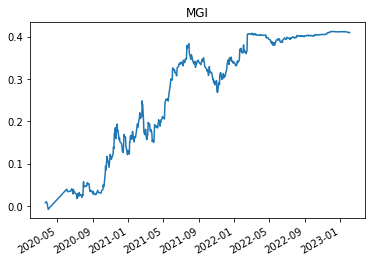

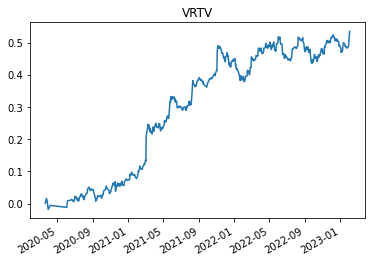

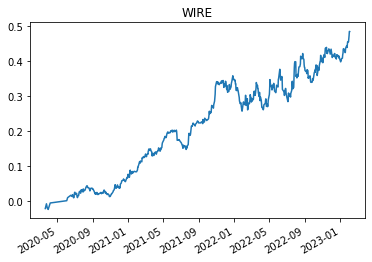

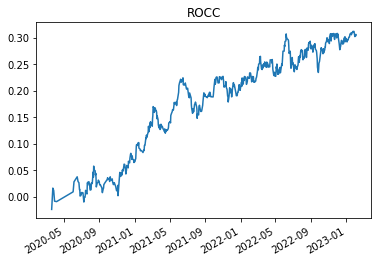

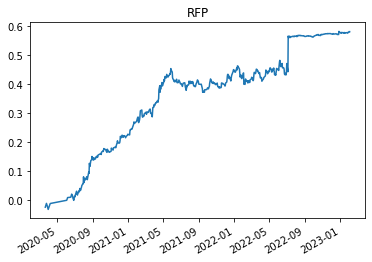

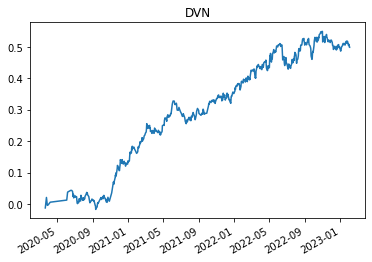

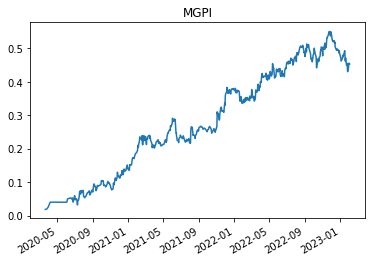

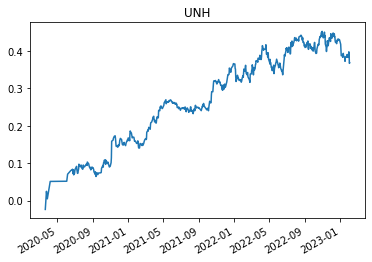

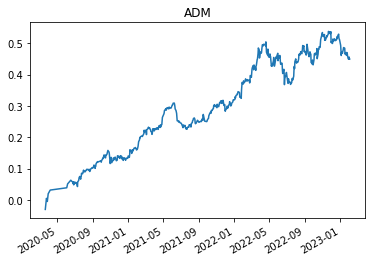

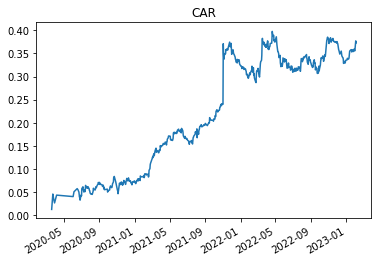

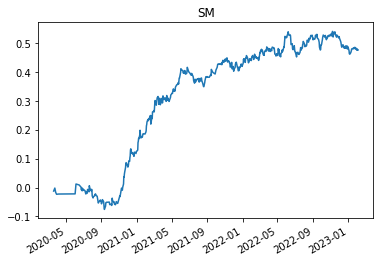

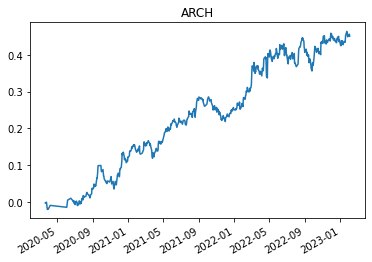

DASR    3.412358
SR      2.917290
dtype: float64


,HCC,JMSB,ESTE,AR,TRGP,LXU,DDS,TWI,MGI,VRTV,WIRE,ROCC,RFP,DVN,MGPI,UNH,ADM,CAR,SM,ARCH
DASR,0.003395,0.00311,0.003101,0.003009,0.002979,0.002977,0.002936,0.002836,0.002829,0.002769,0.002717,0.002706,0.002694,0.002668,0.002665,0.002648,0.002635,0.002603,0.002578,0.002564
SR,1.607307,1.38804,1.298275,1.746765,1.872105,1.653570,2.246672,2.061199,1.484882,1.840302,1.701473,1.164434,1.966661,1.741289,1.611642,1.360563,1.600997,1.372094,1.676986,1.605126


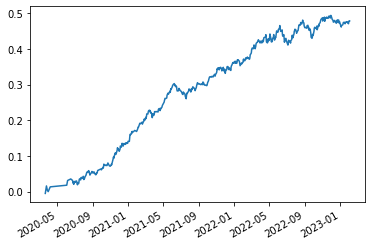

In [55]:
n_largest_dasr = drift_adjusted_sharpe_ratios_t_stat.loc['DASR'].nlargest(20).index

agg_n_largest_rets = {}
for ticker in n_largest_dasr:
    agg_n_largest_rets[ticker] = backtest.scale_vol(new_returns[ticker]) 
    backtest.cumulative_returns(agg_n_largest_rets[ticker]).plot(title=ticker)
    agg_n_largest_rets[ticker] *=1/len(n_largest_dasr)
    plt.show()

pd.DataFrame(agg_n_largest_rets).to_clipboard()
agg_n_largest_rets = pd.DataFrame(agg_n_largest_rets).sum(1)
backtest.cumulative_returns(agg_n_largest_rets).plot()
print(drift_adjusted_sharpe_ratio(returns = agg_n_largest_rets, normalize_residuals='Min-Max'))

drift_adjusted_sharpe_ratios_t_stat[drift_adjusted_sharpe_ratios_t_stat.loc['DASR'].nlargest(20).index]

Compute top 20 SRs and plot the top 20 SR stocks' cumulative returns

Index(['MPC', 'MCK', 'FLNG'], dtype='object')


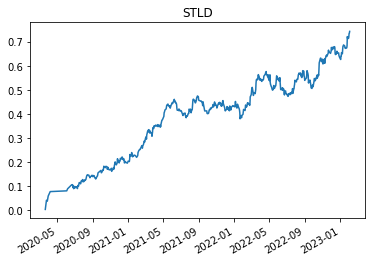

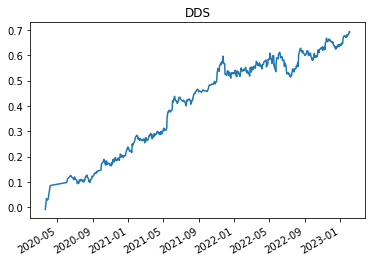

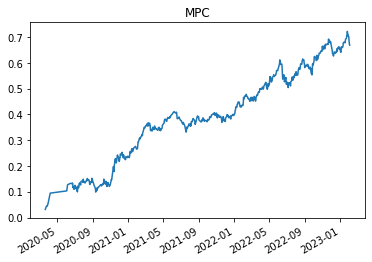

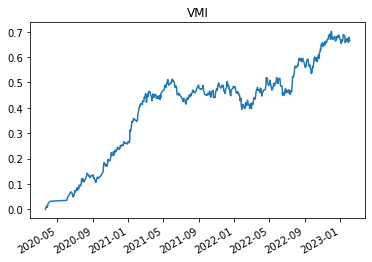

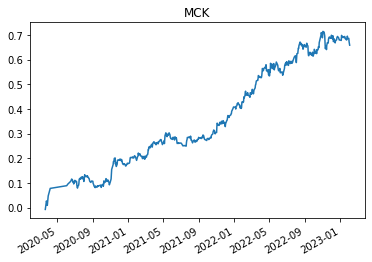

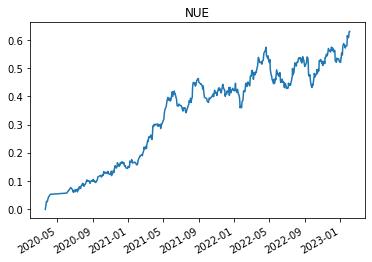

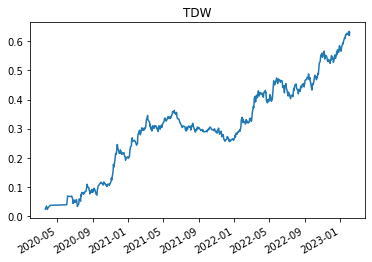

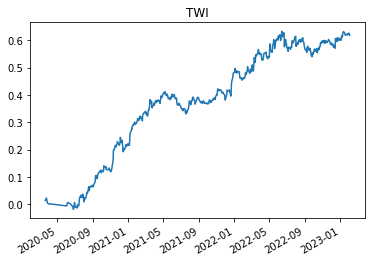

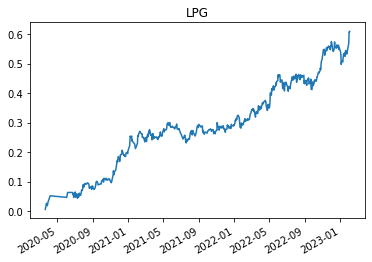

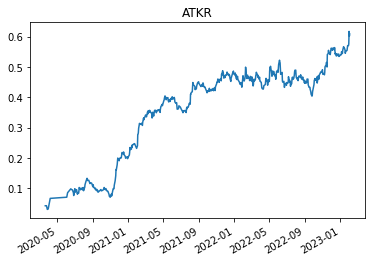

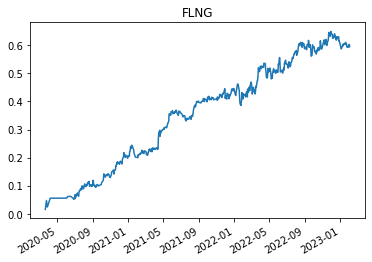

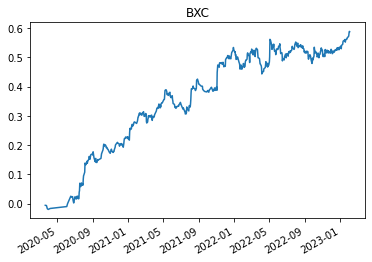

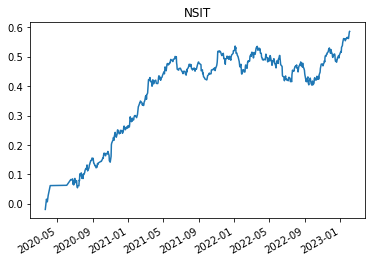

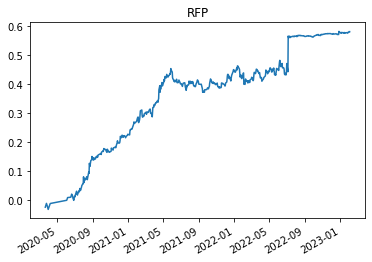

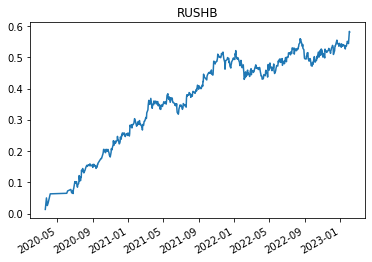

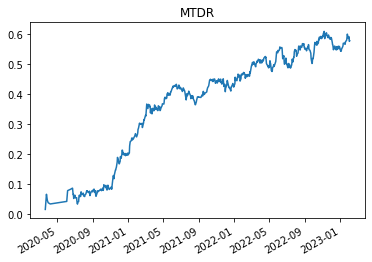

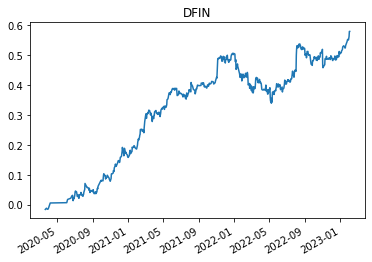

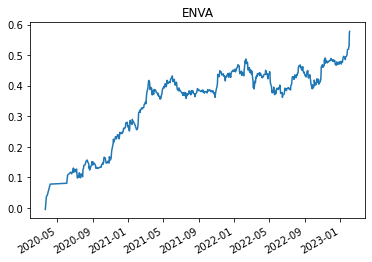

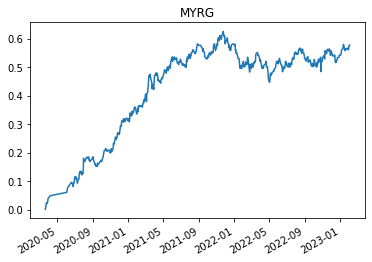

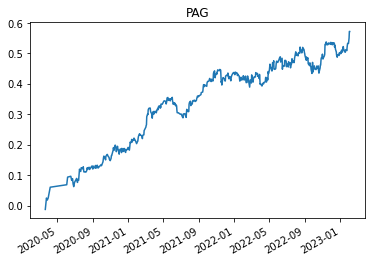

DASR    2.850337
SR      3.237052
dtype: float64


,STLD,DDS,MPC,VMI,MCK,NUE,TDW,TWI,LPG,ATKR,FLNG,BXC,NSIT,RFP,RUSHB,MTDR,DFIN,ENVA,MYRG,PAG
DASR,2.531051,2.331942,4.284107,1.102807,4.025072,1.525129,1.216462,1.972717,2.120935,1.004958,5.248050,1.094075,0.462542,1.988573,1.566184,3.123123,0.778997,0.679264,0.381696,2.426545
SR,2.372966,2.246672,2.189564,2.182527,2.164056,2.095222,2.093988,2.061199,2.038820,2.036818,2.000206,1.982967,1.977741,1.966661,1.963638,1.960850,1.960106,1.956331,1.955939,1.939792


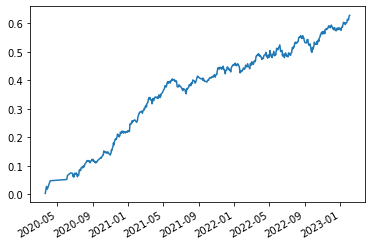

In [61]:
# Plot best 20 SR stocks
print(drift_adjusted_sharpe_ratio_normalized_cum_rets.loc['SR'].nlargest(20).index.intersection(drift_adjusted_sharpe_ratio_normalized_cum_rets.loc['DASR'].nlargest(20).index))

n_largest_sr = drift_adjusted_sharpe_ratio_normalized_cum_rets.loc['SR'].nlargest(20).index

agg_n_largest_sr_rets = {}

for ticker in n_largest_sr:
    agg_n_largest_sr_rets[ticker] = backtest.scale_vol(new_returns[ticker]) 
    backtest.cumulative_returns(agg_n_largest_sr_rets[ticker]).plot(title=ticker)
    agg_n_largest_sr_rets[ticker] *=1/len(n_largest_sr)
    plt.show()
    
agg_n_largest_sr_rets = pd.DataFrame(agg_n_largest_sr_rets).sum(1)
backtest.cumulative_returns(agg_n_largest_sr_rets).plot()
print(drift_adjusted_sharpe_ratio(agg_n_largest_sr_rets, normalize_residuals='Min-Max'))

drift_adjusted_sharpe_ratio_normalized_cum_rets[drift_adjusted_sharpe_ratio_normalized_cum_rets.loc['SR'].nlargest(20).index]

In [88]:
list_ = np.empty(shape=(100, len(new_returns.iloc[:, 0].dropna().tail(252))))
for i in range(0, 100):
    list_[i] = np.random.choice(new_returns.iloc[:, 0].dropna().tail(252), size=len(new_returns.iloc[:, 0].dropna().tail(252)), replace=False)

In [99]:
list_.to_clipboard()

In [94]:
list_ = pd.DataFrame(list_).T

<AxesSubplot:title={'center':'Randomly Permuted Cumulative Returns of Equal Sharpe Ratio'}>

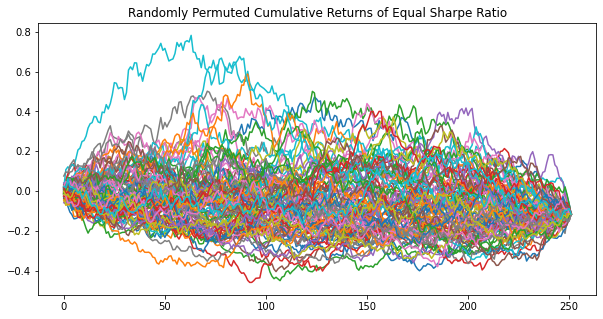

In [98]:
((1+list_).cumprod()-1).plot(legend=False, title='Randomly Permuted Cumulative Returns of Equal Sharpe Ratio', figsize=(10, 5))

Compute DASR (non-normalized residuals) and plot the top 20 DASR stocks' cumulative returns - do not use

In [21]:
drift_adjusted_sharpe_ratios_non_normalized = {}

for ticker, tmp_returns in new_returns.items():
    drift_adjusted_sharpe_ratios_non_normalized[ticker] = drift_adjusted_sharpe_ratio(returns = tmp_returns, normalize_residuals='Non-Normalized')

drift_adjusted_sharpe_ratios_non_normalized = pd.DataFrame(drift_adjusted_sharpe_ratios_non_normalized)
drift_adjusted_sharpe_ratios_non_normalized

,AAPL,MSFT,AMZN,GOOGL,GOOG,NVDA,XOM,TSLA,UNH,JNJ,...,TUP,RLMD,DHC,INSG,VXRT,EGIO,TTCF,YMAB,EIGR,GOSS
DASR,2.830818,1.291385,-1.373195,0.644411,0.657935,1.040983,7.404935,0.910199,6.342366,4.638473,...,-0.579523,-0.827118,-0.632380,-1.931893,0.374108,0.705936,-0.520263,-0.746260,0.689459,1.21953
SR,0.995308,0.662040,-0.062617,0.786788,0.784207,1.074036,1.837862,1.380132,1.360563,1.005742,...,0.407993,-0.234834,-0.111335,-0.425722,0.536290,0.424196,-0.516096,0.031027,0.265486,0.26852


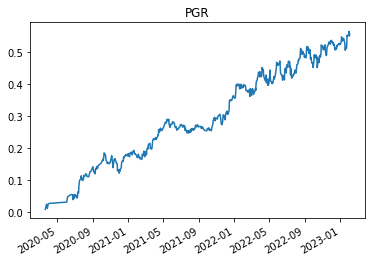

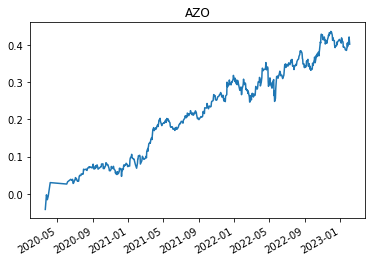

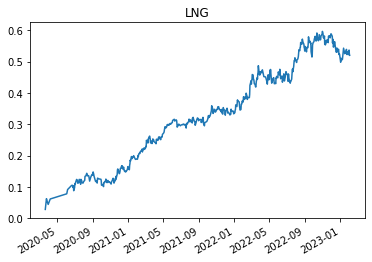

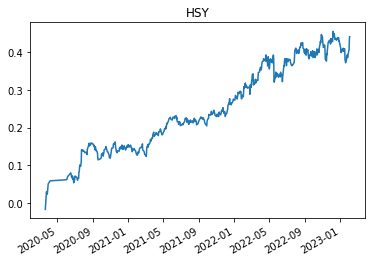

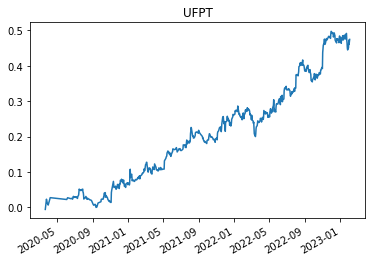

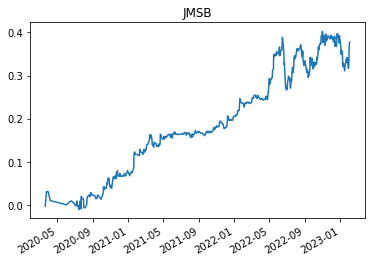

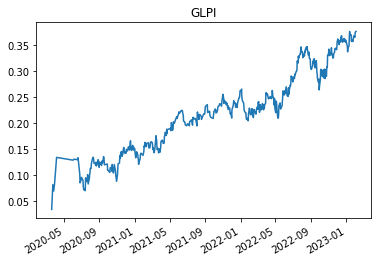

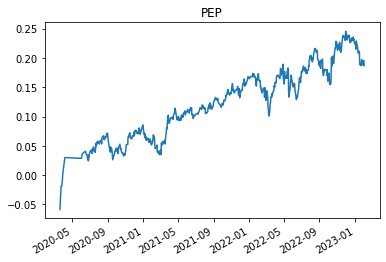

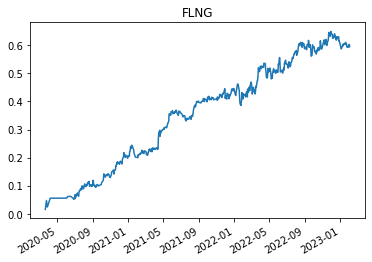

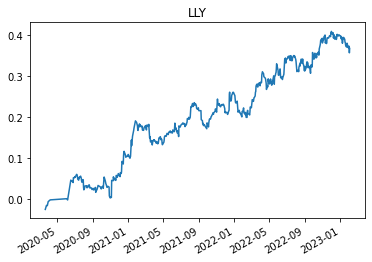

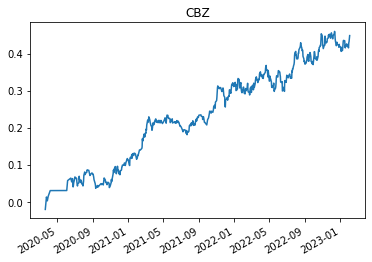

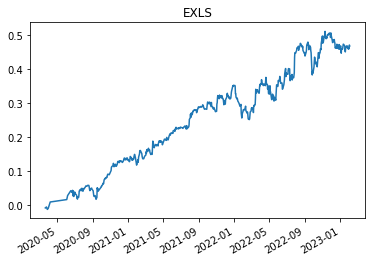

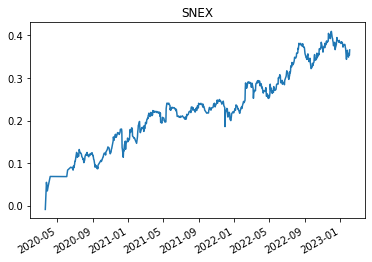

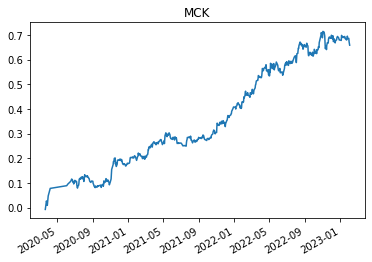

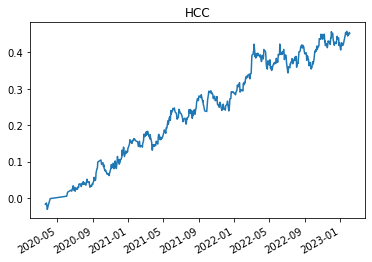

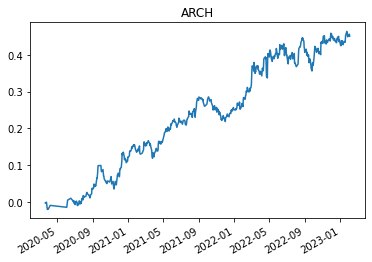

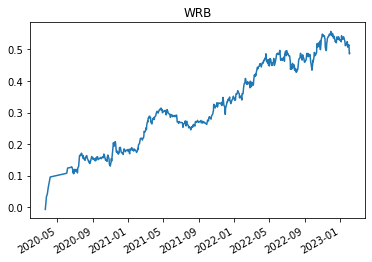

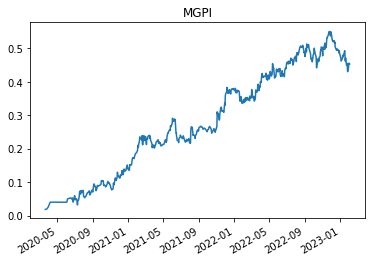

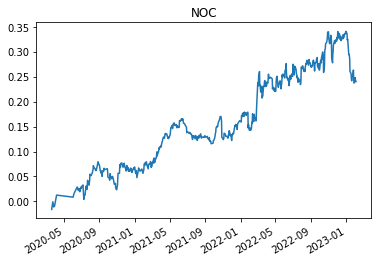

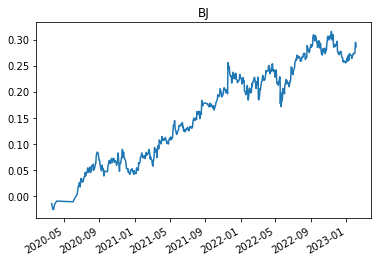

2.852241131964768


,PGR,AZO,LNG,HSY,UFPT,JMSB,GLPI,PEP,FLNG,LLY,CBZ,EXLS,SNEX,MCK,HCC,ARCH,WRB,MGPI,NOC,BJ
DASR,14.291190,11.559639,10.888447,10.804247,10.709237,10.398498,10.014386,9.998943,9.748932,9.634422,9.462855,9.444889,9.249748,9.070861,9.040304,9.012939,8.889375,8.772723,8.707396,8.522654
SR,1.900916,1.461842,1.801709,1.576758,1.673771,1.388040,1.387356,0.766022,2.000206,1.357820,1.598882,1.656357,1.353535,2.164056,1.607307,1.605126,1.710918,1.611642,0.951012,1.101654


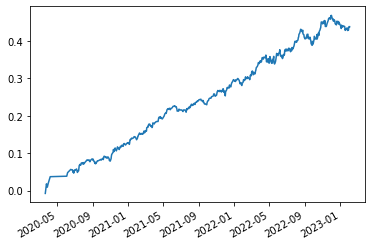

In [23]:
n_largest_dasr = drift_adjusted_sharpe_ratios_non_normalized.loc['DASR'].nlargest(20).index 

agg_n_largest_rets = {}
for ticker in n_largest_dasr:
    agg_n_largest_rets[ticker] = backtest.scale_vol(new_returns[ticker]) 
    backtest.cumulative_returns(agg_n_largest_rets[ticker]).plot(title=ticker)
    agg_n_largest_rets[ticker] *=1/len(n_largest_dasr)
    plt.show()
    
agg_n_largest_rets = pd.DataFrame(agg_n_largest_rets).sum(1)
backtest.cumulative_returns(agg_n_largest_rets).plot()
print(backtest.sharpe_ratio(agg_n_largest_rets))

drift_adjusted_sharpe_ratios_non_normalized[drift_adjusted_sharpe_ratios_non_normalized.loc['DASR'].nlargest(20).index]

Compute DASR (normalized residuals) and plot the top 20 DASR stocks' cumulative returns

In [145]:
drift_adjusted_sharpe_ratios_normalized = {}

for ticker in new_returns.columns:
    drift_adjusted_sharpe_ratios_normalized[ticker] = drift_adjusted_sharpe_ratio(returns = new_returns[ticker], normalize_residuals='Normalized')

drift_adjusted_sharpe_ratios_normalized = pd.DataFrame(drift_adjusted_sharpe_ratios_normalized)
drift_adjusted_sharpe_ratios_normalized

,AAPL,MSFT,AMZN,GOOGL,GOOG,NVDA,XOM,TSLA,UNH,JNJ,...,TUP,RLMD,DHC,INSG,VXRT,EGIO,TTCF,YMAB,EIGR,GOSS
DASR,0.322415,0.096819,-0.063684,0.086467,0.090767,0.161643,0.676462,0.331622,0.815812,0.902739,...,-0.225708,-0.099489,-0.162222,-0.224308,0.095815,0.142229,-0.145850,-0.067754,0.099542,0.147458
SR,0.995308,0.662040,-0.062617,0.786788,0.784207,1.074036,1.837862,1.380132,1.360563,1.005742,...,0.407993,-0.234834,-0.111335,-0.425722,0.536290,0.424196,-0.516096,0.031027,0.265486,0.268520


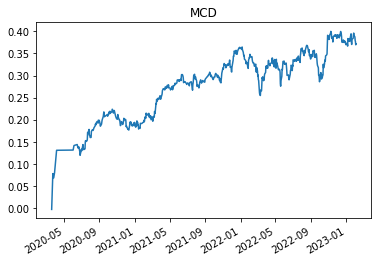

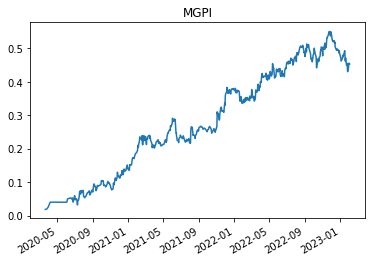

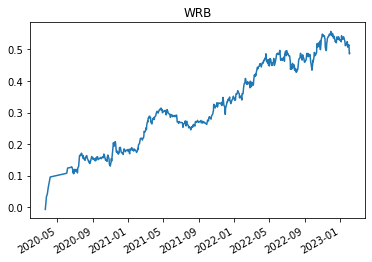

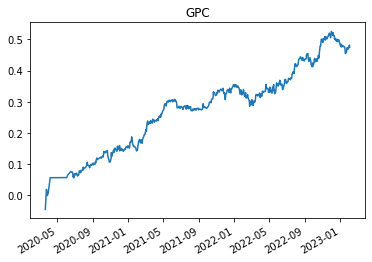

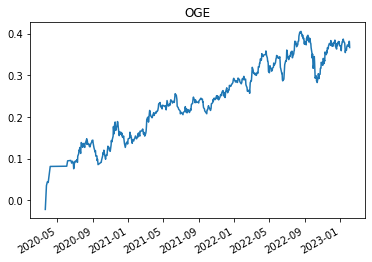

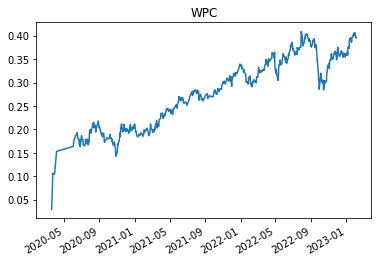

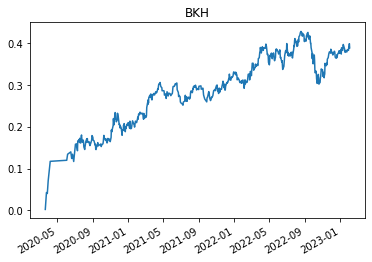

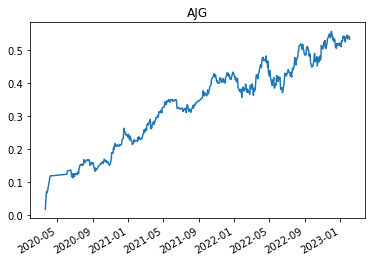

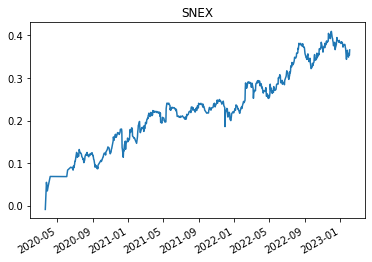

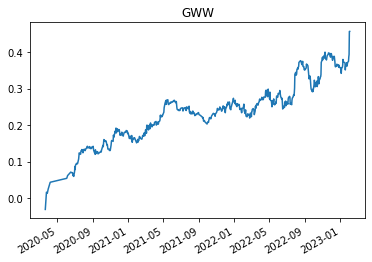

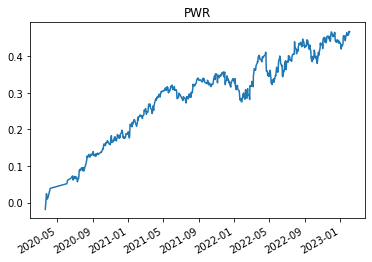

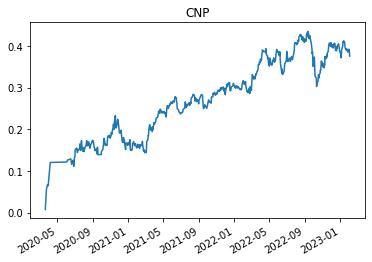

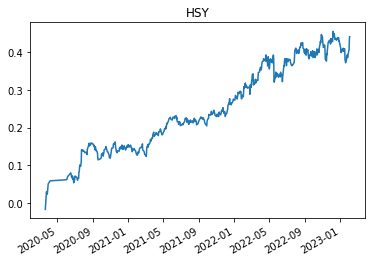

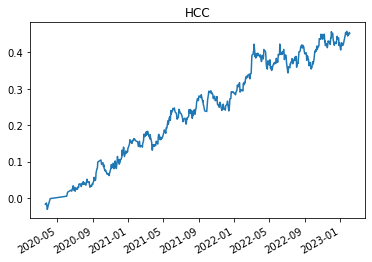

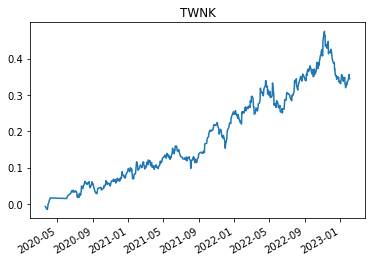

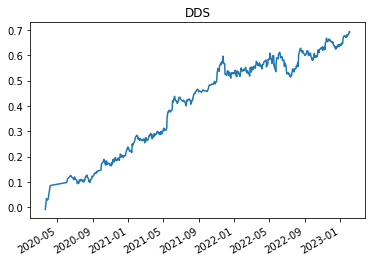

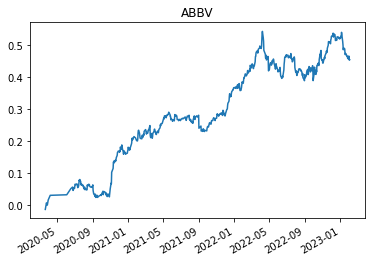

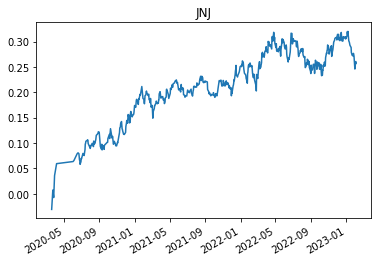

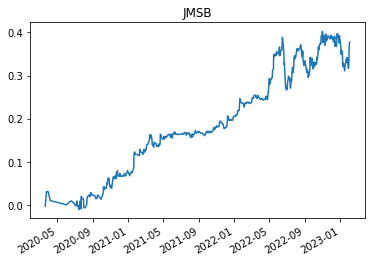

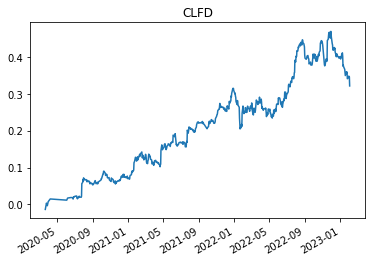

2.4869321465924115


,MCD,MGPI,WRB,GPC,OGE,WPC,BKH,AJG,SNEX,GWW,PWR,CNP,HSY,HCC,TWNK,DDS,ABBV,JNJ,JMSB,CLFD
DASR,1.298614,1.295787,1.269384,1.221011,1.213959,1.133956,1.129511,1.117949,1.094093,1.062533,1.024445,0.974312,0.958341,0.957335,0.932864,0.928973,0.902808,0.902739,0.88707,0.875988
SR,1.371176,1.611642,1.710918,1.674853,1.355376,1.441475,1.422542,1.837535,1.353535,1.623638,1.651694,1.384579,1.576758,1.607307,1.289686,2.246672,1.615060,1.005742,1.38804,1.215502


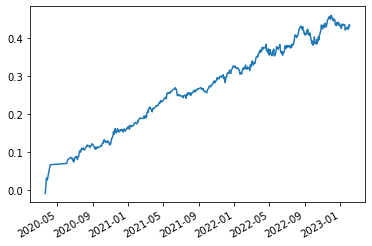

In [146]:
n_largest_dasr = drift_adjusted_sharpe_ratios_normalized.loc['DASR'].nlargest(20).index

agg_n_largest_rets = {}
for ticker in n_largest_dasr:
    agg_n_largest_rets[ticker] = backtest.scale_vol(new_returns[ticker]) 
    backtest.cumulative_returns(agg_n_largest_rets[ticker]).plot(title=ticker)
    agg_n_largest_rets[ticker] *=1/len(n_largest_dasr)
    plt.show()
    
agg_n_largest_rets = pd.DataFrame(agg_n_largest_rets).sum(1)
backtest.cumulative_returns(agg_n_largest_rets).plot()
print(backtest.sharpe_ratio(agg_n_largest_rets))

drift_adjusted_sharpe_ratios_normalized[drift_adjusted_sharpe_ratios_normalized.loc['DASR'].nlargest(20).index]

Compute DASR (STD of residuals) and plot the top 20 DASR stocks' cumulative returns